# Variational Autoencoder for STL Objects

The goal of this notebook is to produce a Variational Autoencoder (VAE) that can encode and then decode Voxel objects.

This VAE is based off of the implementation demonstrated in [this YouTube video](https://www.youtube.com/watch?v=LtpU1yBStlU) [github link](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py). We refer to this VAE as the "Example VAE" in this notebook.

Another good example: https://github.com/hiranumn/DLmodels/blob/master/voxel_modeling/3D-Conv-VAE%20implementation%20(ModelNet%20Chair%20example).ipynb

## Notes

* We still use Thingi10k as our data source. Thingi10k's objects are stl files, so we employ methods explored in stl_voxelization.ipynb to convert each stl file to binvox (a voxel format).
* The Example VAE is written in python with theano and lasagne
* Lasagne's Glorot Uniform initializer \[[docs](https://lasagne.readthedocs.io/en/latest/modules/init.html)\] is the same as Xavier Uniform initializer (Tensorflow's API [docs](https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer)).
* The encoder uses conv3d layers and the decoder uses conv3d_transpose layers; TF describes [here] (https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose) that conv3d_transpose is the opposite of conv3d.

## Env Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

# set seeds for reproducibility
np.random.seed(12)
tf.set_random_seed(12)

## Data Import

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl, plot_mesh
from data.voxels import plot_voxels
from models import MODEL_DIR


thingi = Thingi10k.init10k()
# apply filter
#thingi.filter_by_id(1351747)
thingi.filter_by_tag('animal')
#thingi.filter_to_just_one()
#thingi = Thingi10k.init10()
#thingi = Thingi10k.init10(pctile=.1)
n_input = len(thingi)
n_input

18

In [20]:
class VariationalAutoencoder():
    
    def __init__(self, input_dim, latent_dim, learning_rate, keep_prob, verbose=False, 
                 kl_div_loss_weight=5, recon_loss_weight=5e-4, debug=False, ckpt_dir='voxel_vae'):
        """
        Args:
            kl_div_loss_weight: float, weight for KL Divergence loss when computing total loss
            recon_loss_weight: float, weight for reconstruction loss when computing total loss

        """
        # network and training params
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.verbose = verbose
        self.debug = debug
        self.kl_div_loss_weight = kl_div_loss_weight
        self.recon_loss_weight = recon_loss_weight
        
        self._input_x = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        self._keep_prob = tf.placeholder(dtype=tf.float32)
        self._trainable = tf.placeholder(dtype=tf.bool)

        # add ops to this list as a tuple with (<op name>, <op>) to see them executed, returned, and printed
        # to console during execution
        self._debug_ops = list()
        
        # Construct the TensorFlow Graph
        self.encoder, self.enc_mu, self.enc_sig = self._make_encoder(self._input_x, self._keep_prob, self._trainable)
        self.decoder = self._make_decoder(self.encoder, self._trainable)
        
        self.D_real, self.D_real_logits = self._discriminator(self._input_x, self._trainable)
        self.D_fake, self.D_fake_logits = self._discriminator(self.decoder, self._trainable)
        
        # VAE loss
        self.loss, self.optimizer, self.mean_recon, self.mean_kl = self._make_loss(self._input_x, self.decoder
                                                                                   , self.enc_mu, self.enc_sig)
        # GAN loss
        self.D_loss, self.G_loss, self.D_optim, self.G_optim = self._make_GAN_loss(self.D_real_logits, self.D_fake_logits)
    
    
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()
        self.recons_pre = list()
        self.recons_post = list()
        self.losses_kl_div = list()
        self.losses_recon = list()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _print_shape(self, tensor, name=None):
        if self.verbose:
            if not name:
                name = tensor.name
            print('{}:'.format(name), tensor.shape)
        return
    
    def _make_encoder(self, input_x, keep_prob, trainable):
        
        with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
            # tf conv3d: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d
            # tf glorot init: https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer
            conv1 = tf.layers.batch_normalization(tf.layers.conv3d(input_x,
                                     filters=8,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv1)
            # the Example VAE specifies the activation functions as part of the layer
            # we specify the activation function as a seperate tensor
            # it is unknown if this is the preferred method in Tensorflow, but we know
            # it works from work in the 3D-VAE-GAN notebook
            # we also take advantage of batch_normalization
            # more info here:
            # https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
            # with the hope that it gives speed without sacrificing quality
            # tf batch norm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
            # tf elu (exponential linear unit): https://www.tensorflow.org/api_docs/python/tf/nn/elu

            conv2 = tf.layers.batch_normalization(tf.layers.conv3d(conv1,
                                     filters=16,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv2)

            conv3 = tf.layers.batch_normalization(tf.layers.conv3d(conv2,
                                     filters=32,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv3)

            conv4 = tf.layers.batch_normalization(tf.layers.conv3d(conv3,
                                     filters=64,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv4)

            # Apply one fully-connected layer after Conv3d layers
            # tf dense layer: https://www.tensorflow.org/api_docs/python/tf/layers/dense
            dense1 = tf.layers.batch_normalization(tf.layers.dense(conv4,
                                 units=343,
                                 activation=tf.nn.elu,
                                 kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(dense1)
            flatten = tf.layers.flatten(tf.nn.dropout(dense1, keep_prob))
        
            enc_mu = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_mu)
            enc_sig = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_sig)
                                                  
            # epsilon is a random draw from the latent space
            epsilon = tf.random_normal(tf.stack([tf.shape(dense1)[0], self.latent_dim]))
            self._print_shape(epsilon, 'epsilon')
            enc_z = enc_mu + tf.multiply(epsilon, tf.exp(enc_sig))
            self._print_shape(enc_z, 'z')
        return enc_z, enc_mu, enc_sig


        # apply dropout to prevent overtraining
        # why do we flatten?
        enc_output = tf.layers.flatten(tf.nn.dropout(network_output, keep_prob), name='enc_output')
        self._print_shape(enc_output)
        # transform the network output into the latent vector
        z_mu = tf.layers.dense(enc_output,
                         units=self.latent_dim,
                         # Example VAE does not use an initializer here
                         #kernel_initializer=tf.initializers.glorot_uniform(),
                         name='enc_mu')
        self._print_shape(z_mu)

        # Example VAE uses a custom layer to extract sigma
        # Here we borrow sigma calc from 3D-VAE-GAN
        z_sig = 0.5 * tf.layers.dense(enc_output, units=self.latent_dim, name='enc_sig')
        self._print_shape(z_sig, 'enc_sig')

        # epsilon is a random draw from the latent space
        epsilon = tf.random_normal(tf.stack([tf.shape(enc_output)[0], self.latent_dim]))
        self._print_shape(epsilon, 'epsilon')
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))
        self._print_shape(z, 'z')

        return z, z_mu, z_sig
    
    def _make_decoder(self, input_z, trainable): ## generator
        
        # There is some magic in the Example VAE that adds conditional input based on the
        # class of the image. We do not have that luxury as we are attempting to do this
        # with input that lacks classes.
        # TODO: if poor results, try classes
        with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
            self._print_shape(input_z, 'input_z')

            # Why conv3d_transpose instead of conv3d?
            #
            # from https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose,
            #     "This operation is sometimes called "deconvolution" after Deconvolutional Networks,
            #      but is actually the transpose (gradient) of conv3d rather than an actual deconvolution."
            #
            # conv3d_transpose: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d_transpose
            dense1 = tf.layers.dense(input_z,
                                     units=343,
                                     kernel_initializer=tf.initializers.glorot_uniform(),
                                     name='dec_dense1')
            self._print_shape(dense1)
            lrelu1 = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable))
            self._print_shape(lrelu1)

            #z = tf.reshape(z, (-1, 1, 1, 1, n_latent))
            reshape_z = tf.reshape(lrelu1, shape=(-1, 7, 7, 7, 1), name='reshape_z')
            self._print_shape(reshape_z)
            #print('reshape_z: ', reshape_z.shape)
            #for value in reshape_z.shape:
            #    print(type(value))

            conv1 = tf.layers.conv3d_transpose(reshape_z,
                                               filters=64,
                                               kernel_size=[3, 3, 3],
                                               strides=(1, 1, 1),
                                               padding='same',
                                               # Example VAE does not mention bias
                                               use_bias=False,
                                               kernel_initializer=tf.initializers.glorot_uniform(),
                                               name='dec_conv1')
            self._print_shape(conv1)
            lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='dec_lrelu2')
            self._print_shape(lrelu2)

            conv2 = tf.layers.conv3d_transpose(lrelu2,
                                               filters=32,
                                               kernel_size=[3, 3, 3],
                                               # Example VAE used .5 stride values, but Tensorflow complains
                                               # of being forced to use a float value here
                                               #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                               strides=(2, 2, 2),
                                               padding='valid',
                                               use_bias=False,
                                               kernel_initializer=tf.initializers.glorot_uniform(),
                                               name='dec_conv2')
            self._print_shape(conv2)
            lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='dec_lrelu3')
            self._print_shape(lrelu3)

            conv3 = tf.layers.conv3d_transpose(lrelu3,
                                               filters=16,
                                               kernel_size=[3, 3, 3],
                                               strides=(1, 1, 1),
                                               # changed to valid to hit correct dimension
                                               padding='same',
                                               use_bias=False,
                                               kernel_initializer=tf.initializers.glorot_uniform(),
                                               name='dec_conv3')
            self._print_shape(conv3)
            lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='dec_lrelu4')
            self._print_shape(lrelu4)

            conv4 = tf.layers.conv3d_transpose(lrelu4,
                                               filters=8,
                                               kernel_size=[4, 4, 4],
                                               #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                               strides=(2, 2, 2),
                                               padding='valid',
                                               use_bias=False,
                                               kernel_initializer=tf.initializers.glorot_uniform(),
                                               name='dec_conv4')
            self._print_shape(conv4)
            lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='dec_lrelu5')
            self._print_shape(lrelu5)

            conv5 = tf.layers.conv3d_transpose(lrelu5,
                                               filters=1,
                                               kernel_size=[3, 3, 3],
                                               strides=(1, 1, 1),
                                               padding='same',
                                               use_bias=False,
                                               kernel_initializer=tf.initializers.glorot_uniform(),
                                               name='dec_conv5')
            self._print_shape(conv5)
            #decoded_output = tf.nn.tanh(conv5)
            decoded_output = tf.nn.sigmoid(conv5)
            #decoded_output = tf.clip_by_value(decoded_output, 1e-7, 1.0 - 1e-7)
            #self._add_debug_op('max decoded_output', tf.math.reduce_max(decoded_output), False)
            #self._add_debug_op('min decoded_output', tf.math.reduce_min(decoded_output), False)
            #self._add_debug_op('mean decoded_output', tf.math.reduce_mean(decoded_output), False)
            #decoded_output = conv5
            self._print_shape(decoded_output)

        return decoded_output
    
    ## add discriminator, GAN
    def _discriminator(self, input_x, trainable):
        # need to clip the values?
        self._print_shape(input_x, 'input_x')

        with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):

            # 1st hidden layer
            conv1 = tf.layers.conv3d(input_x, 128, [3, 3, 3], strides=(2, 2, 2), padding='same', use_bias=False,
                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
            lrelu1 = tf.nn.elu(conv1)
            self._print_shape(lrelu1)
#             # 2nd hidden layer
#             conv2 = tf.layers.conv3d(lrelu1, 256, [3, 3, 3], strides=(2, 2, 2), padding='same', use_bias=False,
#                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
#             lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable))
#             self._print_shape(lrelu2)
#             # 3rd hidden layer
#             conv3 = tf.layers.conv3d(lrelu2, 512, [3, 3, 3], strides=(2, 2, 2), padding='same', use_bias=False,
#                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
#             lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable))
#             self._print_shape(lrelu3)
            # output layer
            #conv4 = tf.layers.conv3d(lrelu3, 1, [4, 4, 4], strides=(1, 1, 1), padding='valid', use_bias=False,
            #                          kernel_initializer=tf.contrib.layers.xavier_initializer())
            conv4 = tf.layers.conv3d(lrelu1, 1, [3, 3, 3], strides=(1, 1, 1), padding='valid', use_bias=False,
                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
            o = tf.nn.sigmoid(conv4)
            self._print_shape(conv4)
            self._print_shape(o)
            
        return o, conv4
    
    
    
    def _make_loss(self, enc_input, dec_output, z_mu, z_sig):
        """
        Info on loss in VAE:
          * https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder
          
        Args:
            enc_input: tensor, input tensor into VAE
            dec_output: tensor, decoded output tensor from VAE

        Return:
            float, 
        """
        
        # Weighted binary cross-entropy for use in voxel loss. Allows weighting of false positives relative to false negatives.
        # Nominally set to strongly penalize false negatives
        # we must clip because values of 0 or 1 will cause errors
        #clipped_input = tf.clip_by_value(tf.nn.sigmoid(enc_input), 1e-7, 1.0 - 1e-7)
        clipped_input = tf.clip_by_value(enc_input, 1e-7, 1.0 - 1e-7)
        clipped_output = tf.clip_by_value(dec_output, 1e-7, 1.0 - 1e-7)
        #self._add_debug_op('max clipped_input', tf.math.reduce_max(clipped_input), False)
        #self._add_debug_op('min clipped_input', tf.math.reduce_min(clipped_input), False)
        #self._add_debug_op('mean clipped_input', tf.math.reduce_mean(clipped_input), False)
        self._add_debug_op('max clipped_output', tf.math.reduce_max(clipped_output), False)
        self._add_debug_op('min clipped_output', tf.math.reduce_min(clipped_output), False)
        self._add_debug_op('mean clipped_output', tf.math.reduce_mean(clipped_output), False)
        bce = -(98.0 * clipped_input * tf.log(clipped_output) + 2.0 * (1.0 - clipped_input) * tf.log(1.0 - clipped_output)) / 100.0
        #self._add_debug_op('bce', bce, False)
        #bce = tf.keras.backend.binary_crossentropy(enc_output, dec_output)
        
        # Voxel-Wise Reconstruction Loss 
        # Note that the output values are clipped to prevent the BCE from evaluating log(0).
        recon_loss = tf.reduce_mean(bce, 1)
   
        #recon_loss = tf.reduce_sum(tf.squared_difference(
        #    tf.reshape(dec_output, (-1, self.input_dim ** 3)),
        #    tf.reshape(self._input_x, (-1, self.input_dim ** 3))), 1)
        
        kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)

        mean_kl = tf.reduce_sum(kl_divergence)
        #self._add_debug_op('mean_kl', mean_kl, False)
        mean_recon = tf.reduce_sum(recon_loss)
        #self._add_debug_op('mean_recon', mean_recon, False)

        # tf reduce_mean: https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
        loss = tf.reduce_mean(self.kl_div_loss_weight * kl_divergence + self.recon_loss_weight * recon_loss)
        #self._add_debug_op('loss', loss, False)
        # remove kl for fun
        #loss = tf.reduce_mean(self.recon_loss_weight * recon_loss)
        
        #optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)

        return loss, optimizer, mean_recon, mean_kl
    
    def _make_GAN_loss(self, D_real_logits, D_fake_logits):

        D_loss_real = tf.reduce_mean(D_real_logits)
        D_loss_fake = tf.reduce_mean(D_fake_logits)
        D_loss = D_loss_real - D_loss_fake
        G_loss = -tf.reduce_mean(D_fake_logits)
        
        D_optim = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(-D_loss)
        G_optim = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(G_loss)
        
        return D_loss, G_loss, D_optim, G_optim


    def _add_debug_op(self, name, op, newline=True):
        self._debug_ops.append((name, op, newline))
        return

    def _print_debug_ops(self, results):
        if self.debug:
            for i, debug_op in enumerate(self._debug_ops):
                msg = 'DEBUG_OP "{}": '.format(debug_op[0])
                if len(debug_op) > 2 and debug_op[2]:
                    msg += '\n'
                msg += '{}'.format(results[i])
                print(msg)
        return

    def train(self, generator, epochs=10, input_repeats=1, display_step=1, save_step=1, viz_data=None):
        
        start = time.time()
        for epoch_num, epoch in enumerate(range(epochs)):

            for batch_num, batch in enumerate(generator()):
                
                if self.verbose:
                    print('Epoch: {}, Batch: {}, Elapsed time: {:.2f} mins'.format(epoch_num, batch_num, (time.time() - start) / 60))
                #print("batch.min()", batch.min())
                #print("batch.max()", batch.max())
                # repeat for extra practice on each shape
                for _ in range(input_repeats):

#                     sess.run(self.D_optim, feed_dict={x_encoder_in: batch, x_discr_in: batch, keep_prob: 0.8, isTrain: True})
#                     sess.run(clip)

                    ops = tuple([self.optimizer, self.loss, self.mean_kl, self.mean_recon
                                 , self.D_loss, self.G_loss, self.D_optim, self.G_optim] + 
                                [op for name, op, _ in self._debug_ops])
                    results = self.sess.run(
                        ops,
                        feed_dict={self._input_x: batch, self._keep_prob:self.keep_prob, self._trainable: True}
                    )
                    _, loss, kl_divergence, recon_loss, D_loss, G_loss, _, _ = results[:8]
                    self._print_debug_ops(results[8:])                   
                    
                    
                if self.verbose:
                    #print('\tKL Divergence = {:.5f}, Reconstruction Loss = {:.5f}'.format(kl_divergence, recon_loss))
                    print('\tKL Divergence = {}, Reconstruction Loss = {}, -D_loss = {}, G_loss = {}'.format(kl_divergence
                                                                                                , recon_loss, -D_loss, G_loss))
                
            if (epoch + 1) % display_step == 0:
                print("Epoch: {}, ".format(epoch + 1) + 
                      "Loss = {:.5f}, ".format(loss) + 
                      "KL Divergence = {:.5f}, ".format(kl_divergence) +
                      "Reconstruction Loss = {:.5f}, ".format(recon_loss) +
                      "-D_Loss = {:.5f}, ".format(-D_loss) +
                      "G_Loss = {:.5f}, ".format(G_loss) +
                      "Elapsed time: {:.2f} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                
                # prepare for generation
                #print(batch[0][0])
                if viz_data is None:
                    viz_data = batch[0]
                self._print_shape(viz_data, 'Example shape (before reshape)')
                recon_input = np.reshape(viz_data, (1, self.input_dim, self.input_dim, self.input_dim, 1))
                self._print_shape(recon_input, 'Example shape')
                
                # generate!
                recon = self.reconstruct(recon_input)
                self._print_shape(recon, 'Recon')

                # prepare for plotting
                recon_input = np.reshape(recon_input, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon_input, 'Example shape (for plotting)')
                recon = np.reshape(recon, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon, 'Recon (for plotting)')
                # network outputs decimals; here we force them to True/False for plotting
                self.recons_pre.append(recon)
                recon = recon > 0.5
                self.recons_post.append(recon)
                # replace all nans with zeros
                #recon = np.nan_to_num(recon)
                
                # save the generated object in case we wish to review later
                path = os.path.join(self.ckpt_dir, 'recon_epoch-{}.npy'.format(epoch))

                # visualize
                self.visualize_reconstruction(recon_input, recon)

            if (epoch + 1) % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))

                print("Model saved in path: {}".format(save_path))
                                       
        return

    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, input_x):
        """
        Use VAE to reconstruct given data
        """
        ops = tuple([self.decoder] + [op for name, op, _ in self._debug_ops])
                    
        results = self.sess.run(ops, 
            feed_dict={self._input_x: input_x, self._keep_prob: 1.0, self._trainable: False})
        
        decoded = results[0]
        self._print_debug_ops(results[1:])
                    
        return decoded
    
    def visualize_reconstruction(self, original_x, reconstructed_x, name=None):
        title = '' if not name else ': {}'.format(name)
        plot_voxels(original_x, title='Original' + title)
        plot_voxels(reconstructed_x, title='Autoencoded' + title)
        return

    def __repr__(self):
        return '<VariationalAutoencoder(input_dim={}, latent_dim={}, learning_rate={}, keep_prob={})>'.format(
            self.input_dim, self.latent_dim, self.learning_rate, self.keep_prob)


## Training

The model is having issues producing an output that is recognizable.

Experiments:
* Large & small datasets produce the same result
* latent_dim variations have no effect
* Too high of a learning rate causes the loss to go down then up and sometimes fluctuate
* Removing dropout (keep_prob=1.0) with lr=0.00001 on a single training example causes loss to go down as expected but output is still not recognizable
* Upping recon_loss_weight seems to cause more variation in decoded output
* Severe upping of recon_loss_weight (recon=5, kl=5e-4) delivered loss of ~5 after 500 epochs on a single training example with 20 input_repeats
* 500 epochs with above settings and RMSPropOptimizer achieved loss of <1 after about 200 epochs; viz still unimpressive
* Increasing recon_loss_weight to 5e5 and dumping recon loss and kl divergence values reveals that recon loss is diminishing. Question: what is the input to recon loss? an array of 1s and 0s or TRUEs and FALSEs? A: 1s and 0s
* Using weight binary cross entropy for recon loss as according to Example VAE shows same loss reduction pattern with still unimpressive recon
* Equalized loss weights yielded no change (at 100 epochs on one square example with 50 input_repeats, viz was all 1s)
* By dumping out counts of True vs False of each recon, I can see that False goes down while True goes up to the point where they are almost all Trues after 50 epochs
* Run through all training examples produces loss of nan
* Added homebaked debug_ops and discovered that the dec_output is nan and not the loss functions!

In [8]:
thingi.get_stl_path(stl_id=20016)

'C:\\Users\\cynth\\desktop\\3d-form\\src\\..\\data\\external\\Thingi10k/raw_meshes\\20016.stl'

Num input = 18
Num batches per epoch = 1.80


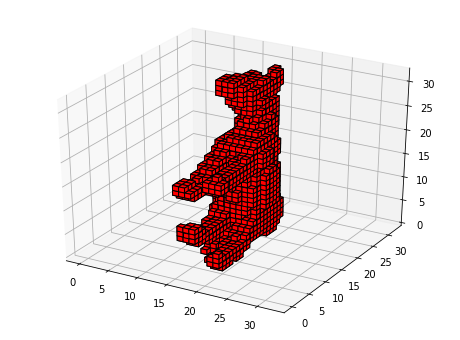

In [9]:
VOXELS_DIM = 32
BATCH_SIZE = 10
print('Num input = {}'.format(n_input))
print('Num batches per epoch = {:.2f}'.format(n_input / BATCH_SIZE))
training_example = thingi.get_voxels(VOXELS_DIM, stl_file=thingi.get_stl_path(stl_id=20006))
plot_voxels(training_example)

encoder/batch_normalization/batchnorm/add_1:0: (?, 30, 30, 30, 8)
encoder/batch_normalization_1/batchnorm/add_1:0: (?, 15, 15, 15, 16)
encoder/batch_normalization_2/batchnorm/add_1:0: (?, 13, 13, 13, 32)
encoder/batch_normalization_3/batchnorm/add_1:0: (?, 7, 7, 7, 64)
encoder/batch_normalization_4/batchnorm/add_1:0: (?, 7, 7, 7, 343)
encoder/batch_normalization_5/batchnorm/add_1:0: (?, 100)
encoder/batch_normalization_6/batchnorm/add_1:0: (?, 100)
epsilon: (?, 100)
z: (?, 100)
input_z: (?, 100)
generator/dec_dense1/BiasAdd:0: (?, 343)
generator/Elu:0: (?, 343)
generator/reshape_z:0: (?, 7, 7, 7, 1)
generator/dec_conv1/conv3d_transpose:0: (?, 7, 7, 7, 64)
generator/dec_lrelu2:0: (?, 7, 7, 7, 64)
generator/dec_conv2/conv3d_transpose:0: (?, 15, 15, 15, 32)
generator/dec_lrelu3:0: (?, 15, 15, 15, 32)
generator/dec_conv3/conv3d_transpose:0: (?, 15, 15, 15, 16)
generator/dec_lrelu4:0: (?, 15, 15, 15, 16)
generator/dec_conv4/conv3d_transpose:0: (?, 32, 32, 32, 8)
generator/dec_lrelu5:0: (?, 

C:\Users\cynth\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0, Batch: 0, Elapsed time: 0.00 mins
DEBUG_OP "max clipped_output": 0.998938262462616
DEBUG_OP "min clipped_output": 0.00396311329677701
DEBUG_OP "mean clipped_output": 0.5112746357917786
	KL Divergence = 1.9449421167373657, Reconstruction Loss = 861.464111328125, -D_loss = 0.03795250877737999, G_loss = -0.050259724259376526
Epoch: 1, Batch: 0, Elapsed time: 0.06 mins
DEBUG_OP "max clipped_output": 0.999017596244812
DEBUG_OP "min clipped_output": 0.01642785407602787
DEBUG_OP "mean clipped_output": 0.6151366233825684
	KL Divergence = 1.9371222257614136, Reconstruction Loss = 582.051025390625, -D_loss = 0.053582433611154556, G_loss = -0.06602740287780762
Epoch: 2, Batch: 0, Elapsed time: 0.12 mins
DEBUG_OP "max clipped_output": 0.9998668432235718
DEBUG_OP "min clipped_output": 0.044075049459934235
DEBUG_OP "mean clipped_output": 0.6952878832817078
	KL Divergence = 1.9566915035247803, Reconstruction Loss = 450.13323974609375, -D_loss = 0.06618565320968628, G_loss = -0.0787754505872

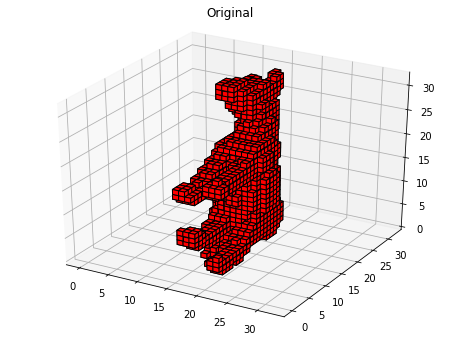

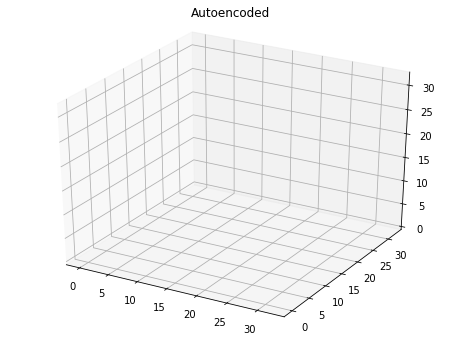

Epoch: 10, Batch: 0, Elapsed time: 0.67 mins
DEBUG_OP "max clipped_output": 0.9994878768920898
DEBUG_OP "min clipped_output": 0.06328383088111877
DEBUG_OP "mean clipped_output": 0.5770304799079895
	KL Divergence = 9.618996620178223, Reconstruction Loss = 380.04449462890625, -D_loss = 0.06605985015630722, G_loss = -0.08009645342826843
Epoch: 11, Batch: 0, Elapsed time: 0.73 mins
DEBUG_OP "max clipped_output": 0.9999350309371948
DEBUG_OP "min clipped_output": 0.05581995099782944
DEBUG_OP "mean clipped_output": 0.5527244806289673
	KL Divergence = 14.321172714233398, Reconstruction Loss = 375.56243896484375, -D_loss = 0.06518901884555817, G_loss = -0.07944848388433456
Epoch: 12, Batch: 0, Elapsed time: 0.79 mins
DEBUG_OP "max clipped_output": 0.999945878982544
DEBUG_OP "min clipped_output": 0.04448116943240166
DEBUG_OP "mean clipped_output": 0.536390483379364
	KL Divergence = 19.493440628051758, Reconstruction Loss = 360.1364440917969, -D_loss = 0.06462815403938293, G_loss = -0.07912129908

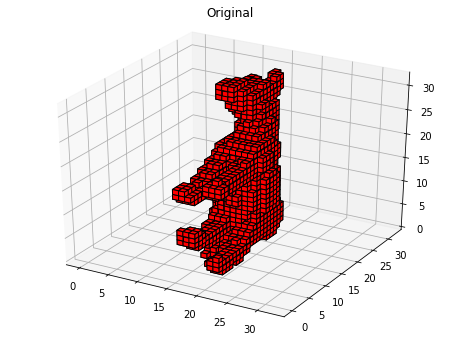

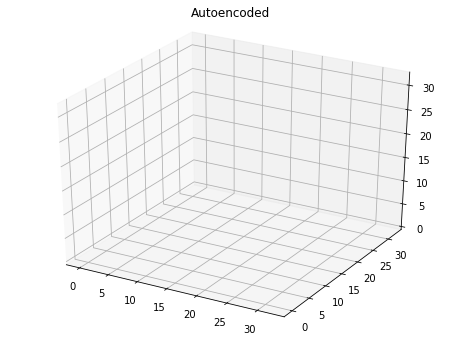

Epoch: 20, Batch: 0, Elapsed time: 1.33 mins
DEBUG_OP "max clipped_output": 0.9996953010559082
DEBUG_OP "min clipped_output": 0.04157987982034683
DEBUG_OP "mean clipped_output": 0.5710093379020691
	KL Divergence = 33.70628356933594, Reconstruction Loss = 317.3818664550781, -D_loss = 0.07745686918497086, G_loss = -0.09424266964197159
Epoch: 21, Batch: 0, Elapsed time: 1.39 mins
DEBUG_OP "max clipped_output": 0.999907374382019
DEBUG_OP "min clipped_output": 0.038020405918359756
DEBUG_OP "mean clipped_output": 0.5611990690231323
	KL Divergence = 37.591407775878906, Reconstruction Loss = 314.6040344238281, -D_loss = 0.07755845785140991, G_loss = -0.09468640387058258
Epoch: 22, Batch: 0, Elapsed time: 1.45 mins
DEBUG_OP "max clipped_output": 0.999946117401123
DEBUG_OP "min clipped_output": 0.02811877429485321
DEBUG_OP "mean clipped_output": 0.5509930849075317
	KL Divergence = 39.80292892456055, Reconstruction Loss = 325.61395263671875, -D_loss = 0.07769859582185745, G_loss = -0.095182336866

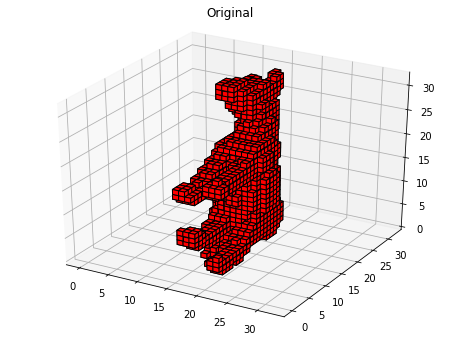

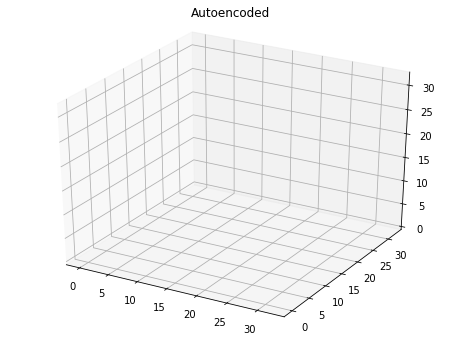

Epoch: 30, Batch: 0, Elapsed time: 2.01 mins
DEBUG_OP "max clipped_output": 0.9998893737792969
DEBUG_OP "min clipped_output": 0.019387176260352135
DEBUG_OP "mean clipped_output": 0.5065987706184387
	KL Divergence = 53.07075500488281, Reconstruction Loss = 288.7479248046875, -D_loss = 0.08593037724494934, G_loss = -0.10674837976694107
Epoch: 31, Batch: 0, Elapsed time: 2.07 mins
DEBUG_OP "max clipped_output": 0.9999226331710815
DEBUG_OP "min clipped_output": 0.011167889460921288
DEBUG_OP "mean clipped_output": 0.49974775314331055
	KL Divergence = 56.89613342285156, Reconstruction Loss = 307.599365234375, -D_loss = 0.08679209649562836, G_loss = -0.10808880627155304
Epoch: 32, Batch: 0, Elapsed time: 2.13 mins
DEBUG_OP "max clipped_output": 0.9998570680618286
DEBUG_OP "min clipped_output": 0.014407976530492306
DEBUG_OP "mean clipped_output": 0.5018986463546753
	KL Divergence = 63.676151275634766, Reconstruction Loss = 303.7877197265625, -D_loss = 0.0891667827963829, G_loss = -0.1109561845

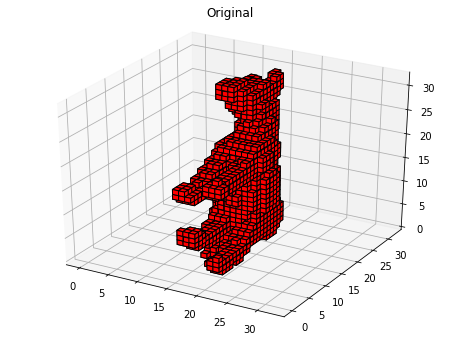

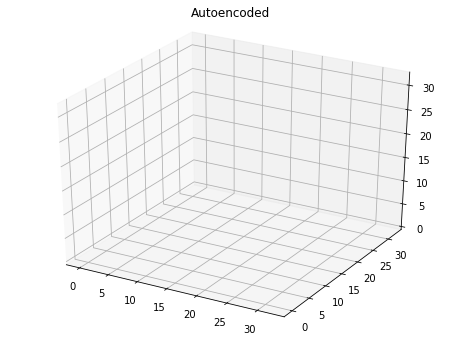

Epoch: 40, Batch: 0, Elapsed time: 2.68 mins
DEBUG_OP "max clipped_output": 0.9999397993087769
DEBUG_OP "min clipped_output": 0.008233247324824333
DEBUG_OP "mean clipped_output": 0.4777044355869293
	KL Divergence = 117.60525512695312, Reconstruction Loss = 255.6468963623047, -D_loss = 0.1011696606874466, G_loss = -0.12728425860404968
Epoch: 41, Batch: 0, Elapsed time: 2.73 mins
DEBUG_OP "max clipped_output": 0.9999803304672241
DEBUG_OP "min clipped_output": 0.004053337033838034
DEBUG_OP "mean clipped_output": 0.4614684581756592
	KL Divergence = 128.4637451171875, Reconstruction Loss = 256.8183898925781, -D_loss = 0.09943901747465134, G_loss = -0.12613080441951752
Epoch: 42, Batch: 0, Elapsed time: 2.80 mins
DEBUG_OP "max clipped_output": 0.9999712705612183
DEBUG_OP "min clipped_output": 0.008237683214247227
DEBUG_OP "mean clipped_output": 0.4494490623474121
	KL Divergence = 141.143798828125, Reconstruction Loss = 243.55755615234375, -D_loss = 0.09880010038614273, G_loss = -0.1260845512

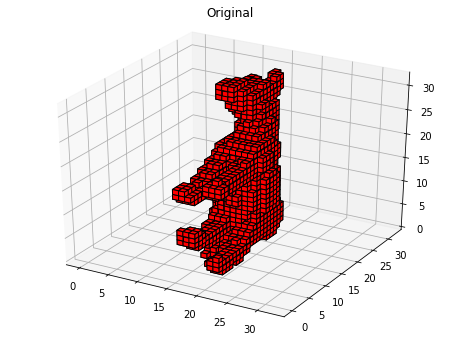

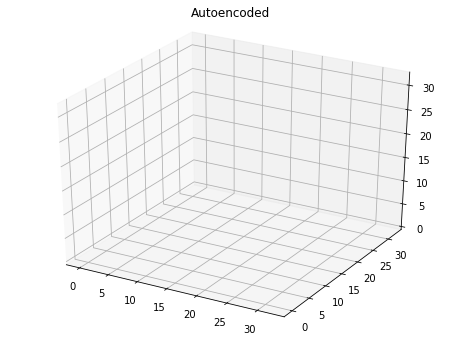

Epoch: 50, Batch: 0, Elapsed time: 3.34 mins
DEBUG_OP "max clipped_output": 0.9999814033508301
DEBUG_OP "min clipped_output": 0.0017419792711734772
DEBUG_OP "mean clipped_output": 0.3813745081424713
	KL Divergence = 291.5728454589844, Reconstruction Loss = 207.69766235351562, -D_loss = 0.09759020805358887, G_loss = -0.13000042736530304
Epoch: 51, Batch: 0, Elapsed time: 3.40 mins
DEBUG_OP "max clipped_output": 0.9999920129776001
DEBUG_OP "min clipped_output": 0.0010146120330318809
DEBUG_OP "mean clipped_output": 0.36939626932144165
	KL Divergence = 317.9148864746094, Reconstruction Loss = 185.5077667236328, -D_loss = 0.09536905586719513, G_loss = -0.12847042083740234
Epoch: 52, Batch: 0, Elapsed time: 3.46 mins
DEBUG_OP "max clipped_output": 0.9999927282333374
DEBUG_OP "min clipped_output": 0.0010174588533118367
DEBUG_OP "mean clipped_output": 0.3632248342037201
	KL Divergence = 294.45367431640625, Reconstruction Loss = 185.26144409179688, -D_loss = 0.09665333479642868, G_loss = -0.130

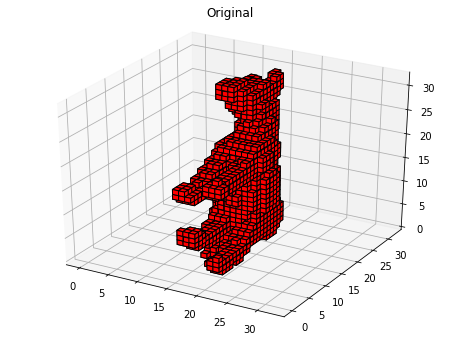

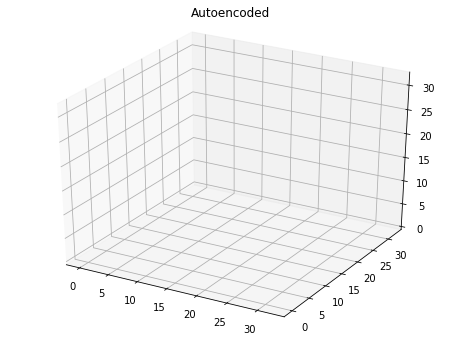

Epoch: 60, Batch: 0, Elapsed time: 4.01 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 0.00014416236081160605
DEBUG_OP "mean clipped_output": 0.29827389121055603
	KL Divergence = 432.1244812011719, Reconstruction Loss = 171.03369140625, -D_loss = 0.08766166120767593, G_loss = -0.12768203020095825
Epoch: 61, Batch: 0, Elapsed time: 4.07 mins
DEBUG_OP "max clipped_output": 0.9999986886978149
DEBUG_OP "min clipped_output": 0.00020293470879551023
DEBUG_OP "mean clipped_output": 0.29466986656188965
	KL Divergence = 422.7493896484375, Reconstruction Loss = 143.72251892089844, -D_loss = 0.08820688724517822, G_loss = -0.129089817404747
Epoch: 62, Batch: 0, Elapsed time: 4.13 mins
DEBUG_OP "max clipped_output": 0.9999997615814209
DEBUG_OP "min clipped_output": 0.00018828151223715395
DEBUG_OP "mean clipped_output": 0.28359800577163696
	KL Divergence = 370.1263122558594, Reconstruction Loss = 142.6278839111328, -D_loss = 0.08563891053199768, G_loss = -0.1273

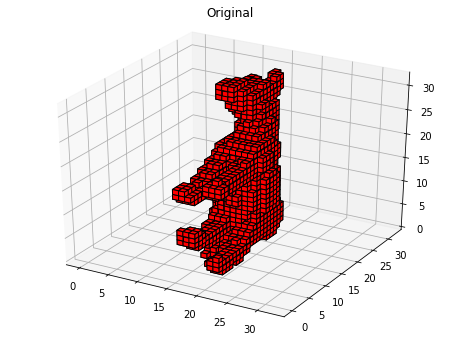

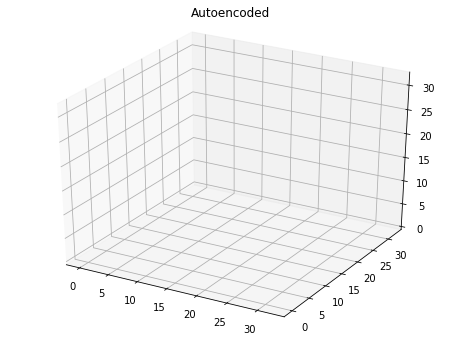

Epoch: 70, Batch: 0, Elapsed time: 4.69 mins
DEBUG_OP "max clipped_output": 0.9999982118606567
DEBUG_OP "min clipped_output": 9.23939878703095e-05
DEBUG_OP "mean clipped_output": 0.25878414511680603
	KL Divergence = 386.57110595703125, Reconstruction Loss = 122.10444641113281, -D_loss = 0.08860855549573898, G_loss = -0.13747283816337585
Epoch: 71, Batch: 0, Elapsed time: 4.75 mins
DEBUG_OP "max clipped_output": 0.999998927116394
DEBUG_OP "min clipped_output": 0.00010610096069285646
DEBUG_OP "mean clipped_output": 0.2548125684261322
	KL Divergence = 433.9084167480469, Reconstruction Loss = 111.83677673339844, -D_loss = 0.08768843114376068, G_loss = -0.13748233020305634
Epoch: 72, Batch: 0, Elapsed time: 4.81 mins
DEBUG_OP "max clipped_output": 0.9999997615814209
DEBUG_OP "min clipped_output": 8.752778376219794e-05
DEBUG_OP "mean clipped_output": 0.24843578040599823
	KL Divergence = 434.9440002441406, Reconstruction Loss = 109.18955993652344, -D_loss = 0.0860692709684372, G_loss = -0.136

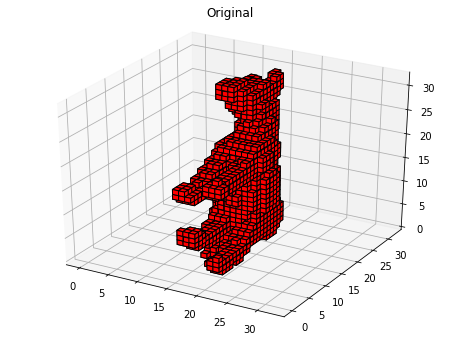

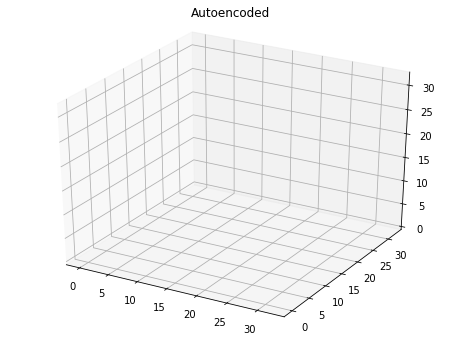

Epoch: 80, Batch: 0, Elapsed time: 5.34 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 4.997511496185325e-05
DEBUG_OP "mean clipped_output": 0.21894200146198273
	KL Divergence = 396.995361328125, Reconstruction Loss = 94.45681762695312, -D_loss = 0.0814107358455658, G_loss = -0.14026734232902527
Epoch: 81, Batch: 0, Elapsed time: 5.40 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 2.1042453226982616e-05
DEBUG_OP "mean clipped_output": 0.21652884781360626
	KL Divergence = 384.97613525390625, Reconstruction Loss = 89.15628814697266, -D_loss = 0.08119042217731476, G_loss = -0.14111930131912231
Epoch: 82, Batch: 0, Elapsed time: 5.46 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 2.11509941436816e-05
DEBUG_OP "mean clipped_output": 0.2130633294582367
	KL Divergence = 363.4149169921875, Reconstruction Loss = 99.6013412475586, -D_loss = 0.08040124177932739, G_loss = -0.1414090

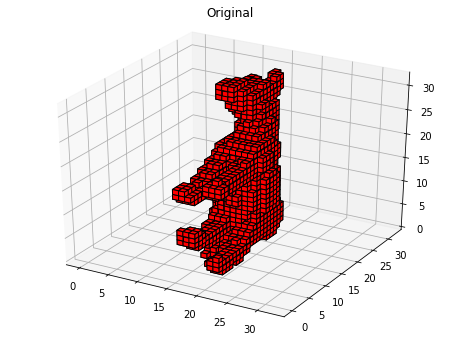

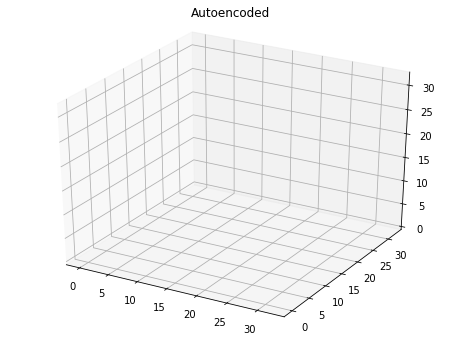

Epoch: 90, Batch: 0, Elapsed time: 5.99 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 1.0936777471215464e-05
DEBUG_OP "mean clipped_output": 0.19945648312568665
	KL Divergence = 347.0831298828125, Reconstruction Loss = 86.98371887207031, -D_loss = 0.08292114734649658, G_loss = -0.15252883732318878
Epoch: 91, Batch: 0, Elapsed time: 6.04 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 6.606296665268019e-06
DEBUG_OP "mean clipped_output": 0.20005981624126434
	KL Divergence = 359.3924560546875, Reconstruction Loss = 86.20791625976562, -D_loss = 0.08474867045879364, G_loss = -0.1553482860326767
Epoch: 92, Batch: 0, Elapsed time: 6.11 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 9.379525181429926e-06
DEBUG_OP "mean clipped_output": 0.19755205512046814
	KL Divergence = 334.8552551269531, Reconstruction Loss = 81.8832015991211, -D_loss = 0.08594563603401184, G_loss = -0.15748

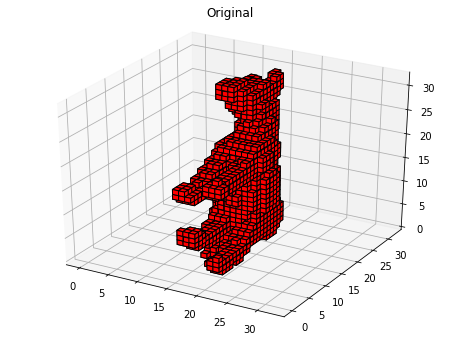

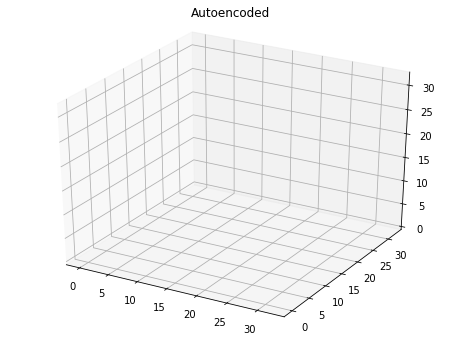

Model saved in path: C:\Users\cynth\desktop\3d-form\src\..\models\voxel_vae\model_epoch-99.ckpt


In [21]:
tf.reset_default_graph()

try:
    vae = VariationalAutoencoder(input_dim=VOXELS_DIM,
                                 latent_dim=100,
                                 learning_rate=0.0001, # 0.00005 for D_lr
                                 keep_prob=1.0,
                                 kl_div_loss_weight=1,
                                 recon_loss_weight=1e4,
                                 verbose=True,
                                 debug=True)

    generator = lambda: thingi.voxels_batchmaker(batch_size=BATCH_SIZE, voxels_dim=VOXELS_DIM, verbose=False)

    vae.train(generator, epochs=100, input_repeats=1, display_step=10, save_step=100,
             viz_data=training_example)
except Exception as exc:
    vae.close()
    raise(exc)

In [41]:
vox_data = thingi.get_voxels(
    VOXELS_DIM,
    stl_file=thingi.get_stl_path(stl_id=20016),
    shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
recon = vae.reconstruct(vox_data)
recon = np.reshape(recon, [VOXELS_DIM, VOXELS_DIM, VOXELS_DIM])


DEBUG_OP "max clipped_output": 0.11894501000642776
DEBUG_OP "min clipped_output": 0.0017324067885056138
DEBUG_OP "mean clipped_output": 0.004740460310131311


In [48]:
recon

array([[[0.10988787, 0.04530786, 0.04544208, ..., 0.04552042,
         0.04531727, 0.10790365],
        [0.04397293, 0.01076802, 0.01080487, ..., 0.01079046,
         0.01075271, 0.03973956],
        [0.04410777, 0.01081167, 0.0108784 , ..., 0.01082155,
         0.01079136, 0.03988656],
        ...,
        [0.04455521, 0.01107451, 0.01125503, ..., 0.01113679,
         0.01095096, 0.03993252],
        [0.04433604, 0.01097378, 0.01110808, ..., 0.01099244,
         0.01085701, 0.0397759 ],
        [0.10254482, 0.03867155, 0.03888937, ..., 0.03867238,
         0.03838811, 0.09255105]],

       [[0.05017672, 0.0142682 , 0.0143292 , ..., 0.01444676,
         0.01434676, 0.05045977],
        [0.01290174, 0.00183363, 0.0018489 , ..., 0.00185629,
         0.00184394, 0.01173854],
        [0.01294768, 0.00184648, 0.00186802, ..., 0.00186466,
         0.00184973, 0.01181039],
        ...,
        [0.01327417, 0.00193221, 0.00196371, ..., 0.00191951,
         0.00187942, 0.01177194],
        [0.0

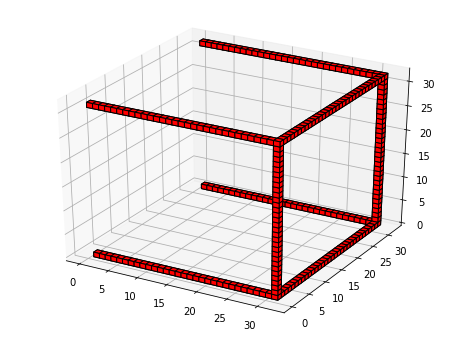

In [52]:
recon = recon > 0.02
plot_voxels(recon)

In [24]:
from skimage import measure
output_dir = os.path.join('_output', '3d-vae-gan')
os.makedirs(output_dir, exist_ok=True)
graphs_dir = os.path.join(output_dir, 'graphs')
os.makedirs(graphs_dir, exist_ok=True)

verts, faces, normals, values = measure.marching_cubes_lewiner(recon, 0)
save_vectors_as_stl(verts[faces], os.path.join(graphs_dir, 'vox_vae_gan_output.stl'))

### Insights and Further Tuning
 - 0.1 is a good option for cutoff
 - add clip to discriminator [-0.5, 0.5]
 - use different learning rate/optimization functions for VAE and GAN loss?
 - use 64x64x64 as input (Be careful! need to update CNN dimensions!)
 - more iterations
 - latent dimension
 - different data sets
 
 Issues:
 
 1. check the loss function by iteration, change as expected?
